In [1]:
import open3d as o3d
import numpy as np
import cv2
from matplotlib import pyplot as plt
from tqdm import tqdm
import png
import os
from tqdm import tqdm
from pathlib import Path
from PIL import Image
from typing import List,Tuple

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


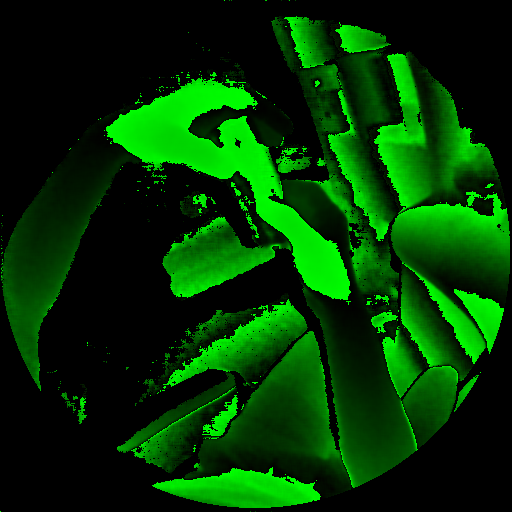

In [19]:
img

In [20]:
arr = np.array(img.getdata())
arr = np.reshape(arr, (512, 512, -1))

In [21]:
arr = arr[:,:,0] * 256 + arr[:,:,1]

In [22]:
np.max(arr)

4090

In [2]:
dparam = np.array([-0.22356547153865305, 0.03186705146154515, 0, 0, 0])

In [3]:
def depth_to_colormapjet(depth):
    depth_color = depth.copy()
    min_d, max_d = np.min(depth_color), np.max(depth_color)
    depth_color = depth_color * 255. / (max_d - min_d)  # - min_d
    depth_color = np.uint8(depth_color)

    depth_color = cv2.applyColorMap(depth_color, cv2.COLORMAP_JET)
    
    return depth_color

In [4]:
# Radial distortion?
def depthConversion(PointDepth, K):
    H = PointDepth.shape[0]
    W = PointDepth.shape[1]
    
    f = K[0,0]
    cx = K[0,2]
    cy = K[1,2]

    columns, rows = np.meshgrid(np.linspace(0, W-1, num=W), np.linspace(0, H-1, num=H))
    distance_from_center = ((rows - cy)**2 + (columns - cx)**2) ** 0.5
    plane_depth = PointDepth / (1 + (distance_from_center / f)**2) ** 0.5

    return plane_depth

In [5]:
def generatepointcloud(depth, K):
    Fx = K[0,0]
    Fy = K[1,1]
    Cx = K[0,2]
    Cy = K[1,2]
    
    rows, cols = depth.shape
    c, r = np.meshgrid(np.arange(cols), np.arange(rows), sparse=True)
    depth_scale = 1
    z = depth * depth_scale

    x = z * (c - Cx) / Fx
    y = z * (r - Cy) / Fy
    points = np.dstack((x, y, z))
    points = points.reshape(-1, 3)
    points = points[~np.all(points == 0, axis=1)]
    return points

In [6]:
def create_point_cloud_from_depth(depth, K_depth, remove_outlier=True, remove_close_to_cam=300):
    # Get rid of radial distortion?
    img2d_converted = depthConversion(depth, K_depth)

    points = generatepointcloud(img2d_converted, K_depth)
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)

    if remove_outlier:
        pcd, _ = pcd.remove_radius_outlier(nb_points=10, radius=10)

    if remove_close_to_cam > 0:
        center = np.array([0, 0, 0])
        R = np.eye(3)
        extent = np.array([remove_close_to_cam, remove_close_to_cam, remove_close_to_cam])
        bb = o3d.geometry.OrientedBoundingBox(center, R, extent)
        close_points_indices = bb.get_point_indices_within_bounding_box(pcd.points)
        pcd = pcd.select_by_index(close_points_indices, invert=True) #select outside points
        bb.color = np.array([0.1, 0.1, 0.7])

    return pcd

In [7]:
    def __init__(self, name: str, path: Path):
        self.name = name
        self.timeStamp = -1
        self.M = np.zeros((4,4))
        self.path = path
        #self.img = o3d.io.read_image(path.joinpath(f"{name}.png").as_posix())
        
    def readTimeStampExtrinsics(self, f):
        self.timeStamp = int(f.readline())
        # Read extrinsic matrix
        for i in range(4):
            self.M[i,:] = np.array(list(map(lambda x: float(x), f.readline().strip().split(", "))))


    def __lt__(self, other):
        return self.timeStamp < other.timeStamp
    def __le__(self, other):
        return self.timeStamp <= other.timeStamp
    def __gt__(self, other):
        return self.timeStamp > other.timeStamp
    def __ge__(self, other):
        return self.timeStamp >= other.timeStamp


In [8]:
class DepthFrame(Frame):
    def __init__(self, name: str):
        super().__init__(name, Path("ImageCloud", "depth"))
        self.K = np.eye(3, 4)
        r = png.Reader(filename=self.path.joinpath(f"{name}.png"))
        self.img = np.fliplr(np.flip(np.vstack(list(map(np.uint16, r.asDirect()[2]))).astype(np.float32)[:,1::4]))
        
        
    def readMetadata(self):
        with open(depthPath.joinpath(f"meta_{self.name}.txt")) as f:
            super().readTimeStampExtrinsics(f)
            x = []
            y = []
            u = []
            v = []
            for points in f:
                elements = points.split(", ")
                x.append(float(elements[0]))
                y.append(float(elements[1]))
                u.append(float(elements[2]))
                v.append(float(elements[3]))
            
            x = np.array(x)
            xparam = np.linalg.lstsq(np.column_stack((x, np.ones_like(x))), u, rcond=None)[0]
            self.K[0,0] = xparam[0]
            self.K[0, 2] = xparam[1]
            
            y = np.array(y)
            yparam = np.linalg.lstsq(np.column_stack((y, np.ones_like(y))), v, rcond=None)[0]
            self.K[1,1] = yparam[0]
            self.K[1, 2] = yparam[1]
            return self
            
        
    def undistort(self, distortion_parameters: np.ndarray):
        self.img = cv2.undistort(self.img, self.K[:,:3], distortion_parameters, None, self.K[:,:3])
        return self

NameError: name 'Frame' is not defined

In [442]:
class ColorFrame(Frame):
    def __init__(self, name: str):
        super().__init__(name, Path("ImageCloud", "rgb"))
        self.img = cv2.imread(self.path.joinpath(f"{name}.png").as_posix())
        
    def readMetadata(self):
        with open(rgbPath.joinpath(f"meta_{self.name}.txt")) as f:
            super().readTimeStampExtrinsics(f)
            return self

In [443]:
depthPath = Path("ImageCloud", "depth")
rgbPath = Path("ImageCloud", "rgb")
depth_images = filter(lambda x: x.endswith(".png"), os.listdir(depthPath.as_posix()))
rgb_images = filter(lambda x: x.endswith(".png"), os.listdir(rgbPath.as_posix()))

In [444]:
drop_extension = lambda x: x.split(".")[0]
depth_names = (drop_extension(img) for img in depth_images)
rgb_names = (drop_extension(img) for img in rgb_images)

In [445]:
depth_frames = (DepthFrame(name).readMetadata() for name in depth_names)
rgb_frames = (ColorFrame(naggme).readMetadata() for name in rgb_names)

In [446]:
undistorted = (frame.undistort(dparam) for frame in depth_frames)

In [447]:
pc = (create_point_cloud_from_depth(df.img, df.K) for df in undistorted)

In [448]:
cloud = next(pc)

In [450]:
vis = o3d.visualization.Visualizer()
vis.create_window()
opt = vis.get_render_option()
opt.point_size = 4

[Open3D WARNING] GLFW Error: GLX: Failed to create context: GLXBadFBConfig
[Open3D WARNING] Failed to create window


libGL error: MESA-LOADER: failed to open swrast: /home/kuenzi/miniconda3/envs/thesis/bin/../lib/libstdc++.so.6: version `GLIBCXX_3.4.30' not found (required by /usr/lib/dri/swrast_dri.so) (search paths /usr/lib/dri, suffix _dri)
libGL error: failed to load driver: swrast


In [ ]:
adsfsadf

In [ ]:
depth_list = list(undistorted)
rgb_list = list(rgb_frames)
cmp = lambda x: x.timeStamp
depth_list.sort(key=cmp)
rgb_list.sort(key=cmp)

In [ ]:
# Assumes that the input lists are sorted!
def pair_closest_frames(depth: List[DepthFrame], rgb: List[ColorFrame]) -> List[Tuple[DepthFrame, ColorFrame]]:
    def get_closest_color_frame(df: DepthFrame) -> ColorFrame:
        idx = np.searchsorted(rgb, df)
        if idx == len(rgb):
            return rgb[-1]
        if idx == 0:
            return rgb[0]
        if df.timeStamp - rgb[idx-1].timeStamp < rgb[idx].timeStamp - df.timeStamp:
            return rgb[idx-1]
        return rgb[idx]
    
    return [(df, get_closest_color_frame(df)) for df in depth]

In [ ]:
paired = pair_closest_frames(depth_list, rgb_list)

In [ ]:
paired[0]

In [ ]:
diff = list(map(lambda x: abs(x[0].timeStamp - x[1].timeStamp), paired))